# Convolution Function

In [1]:
"""
Question (a)

Implement your own conv functions which performs convolution operation without using any neural network packages.
Make sure to handle all possible edge cases to receive full credits.
Keep in mind that height and width of the given image or filter are not always the same.
"""

import numpy as np


def convolution_naive(image, filter, stride=1, padding=0):
    """Performs 2D convolution operation with "4 nested for-loops".

    Args:
    - image: 2D numpy array
    - filter: 2D numpy array
    - stride, padding: integers

    Returns:
    - 2D numpy array : convolution results of the given image and filter.
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """

    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape

    # Filter compatibility check
    if (filter_width > image_width) or (filter_height > image_height):
        return None

    # Padding
    if padding > 0:
        image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    padded_height, padded_width = image.shape

    # Stride compatibility check
    if (padded_height - filter_height) % stride != 0 or (padded_width - filter_width) % stride != 0:
        return None

    output_height = (padded_height - filter_height) // stride + 1
    output_width = (padded_width - filter_width) // stride + 1

    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            conv_sum = 0
            for m in range(filter_height):
                for n in range(filter_width):
                    conv_sum += image[i * stride + m, j * stride + n] * filter[m, n]
            output[i, j] = conv_sum

    return output


def convolution_vectorized(image, filter, stride=1, padding=0):
    """Performs 2D convolution operation with "less than or equal to 2 nested for-loops".

    Args:
    - image: 2D numpy array
    - filter: 2D numpy array
    - stride, padding: integers

    Returns:
    - 2D numpy array : convolution results of the given image and filter..
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """

    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape

    # Filter compatibility check
    if (filter_width > image_width) or (filter_height > image_height):
        return None

    # Padding
    if padding > 0:
        image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    padded_height, padded_width = image.shape

    # Stride compatibility check
    if (padded_height - filter_height) % stride != 0 or (padded_width - filter_width) % stride != 0:
        return None

    output_height = (padded_height - filter_height) // stride + 1
    output_width = (padded_width - filter_width) // stride + 1

    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(image[i * stride : i * stride + filter_height,
                                         j * stride : j * stride + filter_width] * filter)

    return output

In [2]:
image = np.random.randint(10, size=(256, 256))
filter = np.random.randint(10, size=(16, 16))
stride = 1
padding = 0

print("Compare the time complexity of 2 convolution operations")
print("1. Convolution operation with 4 nested loops")
%timeit -n 3 -r 1 convolution_naive(image, filter, stride, padding)
print("2. Convolution operation with less than or equal to 2 nested loops")
%timeit -n 3 -r 1 convolution_vectorized(image, filter, stride, padding)

Compare the time complexity of 2 convolution operations
1. Convolution operation with 4 nested loops
7.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
2. Convolution operation with less than or equal to 2 nested loops
406 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [3]:
image = np.array([[1, 2, 3, 2, 1], [2, 3, 4, 5, 6], [-1, -2, -3, -4, -5], [0, 0, 1, 0, 0], [7, 1, 7, 1, 7]])
filter = np.array([[1, 0], [0, 1]])
stride = 3
padding = 0

# Expected Result for each convolution functions.
# [[4. 8.]
#  [1. 7.]]
print(convolution_naive(image, filter, stride, padding))
print(convolution_vectorized(image, filter, stride, padding))

[[4. 8.]
 [1. 7.]]
[[4. 8.]
 [1. 7.]]


# Import Modules

In [4]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import f1_score

In [5]:
"""
import modules you need
"""

'\nimport modules you need\n'

# Utils

In [6]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    """
    Plots image and labels.

    """
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

In [7]:
def train(model, train_loader, optimizer):
    """
    Trains the model with training data.

    """
    model.train()
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))


def evaluate(model, test_loader):
    """
    Evaluates the trained model with test data.

    """
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = []  # Initialize all_labels
    all_predictions = []  # Initialize all_predictions

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            # Store all labels and predictions for F1 score calculation
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return test_loss, test_accuracy, f1

# CIFAR-10 Data Augmentation

In [8]:
def gaussian_smoothing(image, filter_size=3, sigma=1.0):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    """
    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image


def color_jitter(image):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    """
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

In [9]:
def horizontal_flip(image):
    """Flips the image horizontally.

    Question (b)
    - Do not use TorchVision or OpenCV library for this question.
    - You can solve the problem using numpy only.

    Inputs
    - image: an input image of shape (32, 32, 3).

    Returns
    - image: a horizontally-flipped image of shape (32, 32, 3).
    """
    image = image[:, ::-1, :]

    return image

100%|██████████| 170498071/170498071 [00:01<00:00, 103305722.07it/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


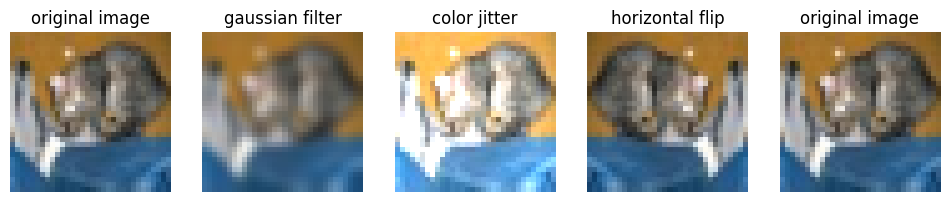

In [10]:
"""
Visualize how the augmentations are applied to a single image.

"""

raw_test = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True)

f, ax = plt.subplots(1, 5)
f.set_size_inches(12, 3)
x = raw_test[0][0]
x = np.array(x)
g = gaussian_smoothing(x)
j = color_jitter(x)
h = horizontal_flip(x)
title = ['original image', 'gaussian filter', 'color jitter', 'horizontal flip', 'original image']
for i, img in enumerate([x, g, j, h, x]):
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(title[i], color='k')

In [11]:
###
# Question (b)
# Briefly explain whether horizontal flip is a good augmentation method for image classification task.
###

Horizontal flip is a good augmentation method for image classification task in that they are effective in simulating real world variations. This can be explained more effectively by contrasting with vertical flip. In many real-world scenarios where gravity takes place, it is not often possible for the object in the image to be vertically flipped. For example, it is less likely for the car to be upside-down, but horizontal flipping can happen according to the position in which the object is viewed. A horizontally flipped car or animal still needs to be recognized correctly. Therefore, horizontal flipping helps the model learn such variations.

In [12]:
class CustomDataset(Dataset):
    def __init__(self, train, prob=0.5, data_dir="./CIFAR_10"):
       
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
        
        return self.data[idx]

    def transform(self, image):
        """
        Apply stochastic data augmentation to the given image.

        Question (c)
        - Convert the given RGB image into BGR scale using opencv library.
        - Apply random augmentation (gaussian smoothing, color jitter, and horizontal flip).
        - Random augmentation is applied with the probability of self.prob.
        - If self.prob = 0.5, 5 out of 10 images will be augmented on average.
        - Convert the augmented image back to RGB scale for training.

        Inputs
        - image: numpy array of an input image of shape (32,32,3).
        Returns
        - image: numpy array of the augmented input image with shape (32,32,3).
        """

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if np.random.rand() < self.prob:
            return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if np.random.rand() < self.prob:
            # Gaussian Smoothing
            image = gaussian_smoothing(image)

        if np.random.rand() < self.prob:
            # Color Jitter (adjusting brightness, contrast)
            image = color_jitter(image)

        if np.random.rand() < self.prob:
            # Horizontal Flip
            image = horizontal_flip(image)

        # Convert BGR back to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image


    def collate_fn(self, data):
        """
        Creates a batch of images and label tensors.

        Question (d)
        - Convert each image in the batch from PIL image to numpy array.
        - Transform the image using self.transform method to apply random augmentation.
        - Normalize the transformed image by mapping the range [0, 255] to range [0, 1].
        - Transpose the (H * W * C) format of the image into (C * H * W) format.
          - To be specific, the dimension of the original image is (32, 32, 3).
          - We want the dimension of the transposed image to be (3, 32, 32).
        - Convert the batch of preprocessed images into PyTorch float tensors.
        - Convert the batch of labels into PyTorch long tensors.
        - Do NOT use torchvision.transforms library!

        Inputs
        - list of tuples, each containing a PIL image and an integer label
        - number of tuples in the list == BATCH SIZE

        Returns
        - batch of image tensors, batch of label tensors
        - size: (BATCH, CHANNEL, HEIGHT, WIDTH), (BATCH)
        """
        batch_x, batch_y = [], []

        for x, y in data:
            # to numpy array
            x = np.array(x)
            # random augmentation
            x = self.transform(x)
            # normalize
            x = x / 255.0
            # transpose
            x = x.transpose(2,0,1)
            # into float tensor
            x = torch.Tensor(x)
            y = torch.Tensor([y])

            batch_x.append(x)
            batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()

        return batch_x, batch_y


Files already downloaded and verified


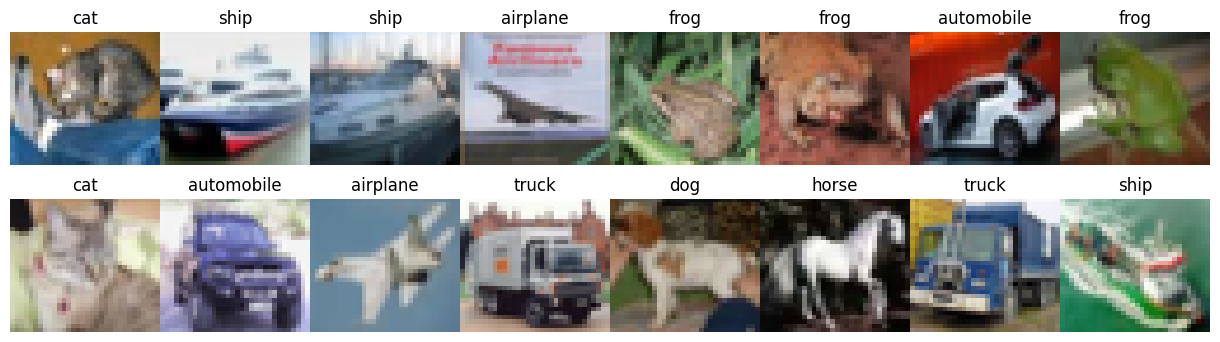

In [13]:
"""
Plot some example images and class labels without applying data augmentation.

"""

raw_test_dataset = CustomDataset(train=False, prob=0, data_dir="./CIFAR_10")
raw_test_loader = DataLoader(dataset=raw_test_dataset, batch_size=16, shuffle=False, collate_fn=raw_test_dataset.collate_fn)

plot_dataset(raw_test_loader)

Files already downloaded and verified
Files already downloaded and verified


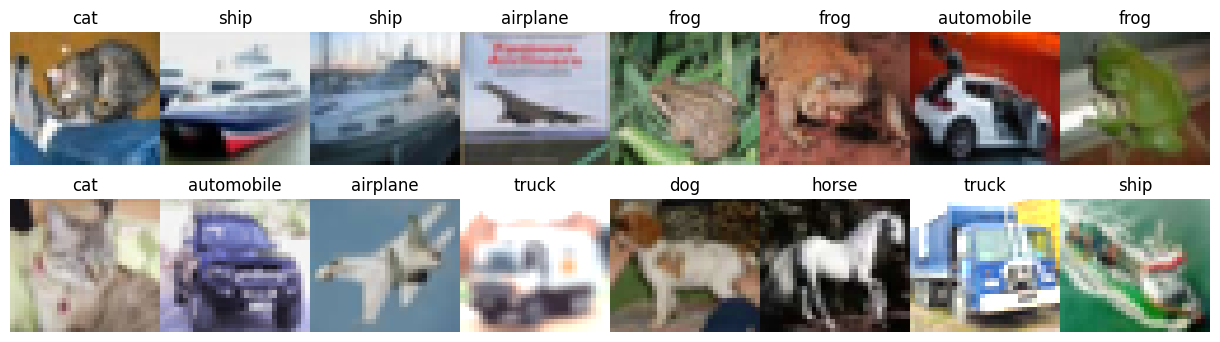

In [14]:
"""
Same examples after applying data augmentation with 50% probability.
If your transform (c) and collate_fn (d) methods have been implemented well, some of the results should look different from the ones above.

"""

train_dataset = CustomDataset(train=True, prob=0.5)
test_dataset = CustomDataset(train=False, prob=0.5)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

plot_dataset(test_loader)

# ConvNet Image Classification

In [15]:
###
# Question (e)
# Train your ConvNet to achieve test accuracy above 70%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###

In [33]:
class ConvNet(nn.Module):
    """
    Builds a ConvNet model.

    Question (e)
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] at least three times,
    - follwed by at least three Linear layers.
    - 3x3 filter is enough, but feel free to use larger filter size.
    - channels used: [10, 32, 64, 128, 256, 512, 1024]
    - you can choose smaller or larger channel size as well.
    - The model may include BatchNormalization, regularizers, and Dropout, but they are not necessary.
    """
    def __init__(self):
        """
        Define the layers that you would like to use in your model.
        """
        super(ConvNet, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)   # Input channels = 3 (RGB), Output channels = 32
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)  # Input channels = 32, Output channels = 64
        self.pool1 = nn.MaxPool2d(2, 2)    # MaxPooling

        # Second Convolution Block
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1) # Input channels = 64, Output channels = 128
        self.conv4 = nn.Conv2d(128, 256, 3, padding = 1) # Input channels = 128, Output channels = 256
        self.pool2 = nn.MaxPool2d(2, 2)    # MaxPooling

        # Third Convolution Block
        self.conv5 = nn.Conv2d(256, 512, 3, padding = 1) # Input channels = 256, Output channels = 512
        self.conv6 = nn.Conv2d(512, 1024, 3, padding = 1) # Input channels = 512, Output channels = 1024
        self.pool3 = nn.MaxPool2d(2, 2)    # MaxPooling

        # Calculate the number of features after the convolutions and pooling
        # This depends on the input size and the structure of your CNN
        # For CIFAR-10 (32x32 images), let's assume the feature size here (you might need to adjust this):
        feature_size = 1024 * 4 * 4

        # Fully Connected Layers
        self.fc1 = nn.Linear(feature_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # Assuming 10 classes for the output

    def forward(self, x):
        # Applying Convolution and Pooling layers
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.pool3(F.relu(self.conv6(F.relu(self.conv5(x)))))

        # Flattening the output for the fully connected layers
        x = x.view(-1, 1024 * 4 * 4)  # Adjust the number of features here based on your pooling and conv layers

        # Applying Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function, as this will be used for a classification task
        return x

In [21]:
"""
Make sure your runtime type is GPU and you are using PyTorch version higher than 1.8!

"""

DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print(torch.cuda.is_available())

Using PyTorch version: 2.1.0+cu118, Device: cuda
True


In [34]:
"""
Load your customized model "ConvNet" and its training settings.
You may choose the number of epochs that you would like to train.
You might want to use different optimizers or learning rates.
"""

EPOCHS = 20
model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [35]:
"""
Train your model "ConvNet" with the augmented CIFAR-10 dataset.
Upon successful training, test accuracy of your model should be above 70%.

"""

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy, test_f1_score = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}, \tTest F1_Score: {:.4f} % \n".format(
        epoch, test_loss, test_accuracy, test_f1_score))

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0228, 	Test Accuracy: 45.82, 	Test F1_Score: 0.4558 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0184, 	Test Accuracy: 57.55, 	Test F1_Score: 0.5642 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0155, 	Test Accuracy: 65.18, 	Test F1_Score: 0.6538 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0146, 	Test Accuracy: 67.45, 	Test F1_Score: 0.6713 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0133, 	Test Accuracy: 70.68, 	Test F1_Score: 0.7008 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0124, 	Test Accuracy: 73.10, 	Test F1_Score: 0.7315 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0119, 	Test Accuracy: 74.39, 	Test F1_Score: 0.7411 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0112, 	Test Accuracy: 75.85, 	Test F1_Score: 0.7597 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0117, 	Test Accuracy: 75.06, 	Test F1_Score: 0.7484 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0107, 	Test Accuracy: 77.09, 	Test F1_Score: 0.7718 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 11], 	Model: ConvNet, 	Test Loss: 0.0110, 	Test Accuracy: 77.13, 	Test F1_Score: 0.7735 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 12], 	Model: ConvNet, 	Test Loss: 0.0106, 	Test Accuracy: 77.66, 	Test F1_Score: 0.7756 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 13], 	Model: ConvNet, 	Test Loss: 0.0105, 	Test Accuracy: 78.12, 	Test F1_Score: 0.7810 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 14], 	Model: ConvNet, 	Test Loss: 0.0112, 	Test Accuracy: 77.92, 	Test F1_Score: 0.7792 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 15], 	Model: ConvNet, 	Test Loss: 0.0111, 	Test Accuracy: 77.16, 	Test F1_Score: 0.7739 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 16], 	Model: ConvNet, 	Test Loss: 0.0114, 	Test Accuracy: 77.24, 	Test F1_Score: 0.7728 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 17], 	Model: ConvNet, 	Test Loss: 0.0111, 	Test Accuracy: 78.81, 	Test F1_Score: 0.7883 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 18], 	Model: ConvNet, 	Test Loss: 0.0112, 	Test Accuracy: 77.82, 	Test F1_Score: 0.7771 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 19], 	Model: ConvNet, 	Test Loss: 0.0125, 	Test Accuracy: 76.95, 	Test F1_Score: 0.7677 % 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 20], 	Model: ConvNet, 	Test Loss: 0.0124, 	Test Accuracy: 77.67, 	Test F1_Score: 0.7753 % 


In [ ]:
###
# Question (f)
# Explain the difference of Accuracy and F1 score.
# Additionally, discuss in what situations it is advantageous to use the F1 Score.
###

Accuracy is the ratio of correctly predicted observations to the total observations. And F1 score is the harmonic mean of precision and recall. Accuracy is a good measure when the target variable classes in the data are nearly balanced.

However, if there is a significant class imbalance, accuracy is not a good measure and F1 score measure is preferred. For example, if the data has 90% of class A and 10% of class B, a model that predicts all data as class A will have 90% accuracy. In this case, F1 score is a better measure. Therefore, F1 score is preferred in applications where false positives and false negatives have different costs like in medical diagnosis. F1 score provides a more balanced measure of a model's performance, taking into account both precision and recall.
